In [5]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types

# Tolerate more task failures
#sc = pyspark.SparkContext(appName="phishingURL-AUTOML-V3-BestModel-Discovery")
#sqlContext = SQLContext(sc)

spark = SparkSession.builder\
.appName("phishingURL-AUTOML-V3-BestModel-Discovery")\
.config("spark.task.maxFailures", "8")\
.getOrCreate()

sqlContext = SQLContext(spark)

import h2o
from h2o.automl import H2OAutoML

import subprocess
subprocess.run('unset http_proxy', shell=True)

h2o.init(ip="localhost",port=54321)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 mins 21 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_siemanalyst_6kvm2r
H2O cluster total nodes:,1
H2O cluster free memory:,4.865 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [2]:
#!/usr/bin/env python
import string
import hashlib
import sys
import re
import numpy as np
from scipy import stats
"""
# -----------------------------------------------------------------------------
# this is the hive entry point:
# parameters are accepted as a tab delimited stream
# the stream must be read and broken
# variables will be assigned to the 'parameters' passed
# as a reference
# PARAMETERS EXPEXTED:
#
# -----------------------------------------------------------------------------
# 
"""
# -----------------------------------------------------------------------------
#
#  GOOD WORDS LIST
# list_values2 = "dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.google.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
# list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
#
# BAD WORDS LIST
# list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"   
# list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
#
#
# BAD DOMAINS LIST
# list_values3 = "27media.urlvalidation.amatorskihokej.gilbertargentina.arcoinhive.track.o7go.cdntc.advancedmactuner.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.webmine.park.above.track.amishbrand.epiphany-walpole.track.o7go.picturesetc.epiphany-walpole.park.above.jsecoin.cometgroup-eg.arenacorporativo.hydra.edos.cl.mail.cometgroup-eg.cometgroup-eg.santoshdiesel.sumtexa.errors.newdatastatsserv.mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.junpiterfutbol.errors.newdatastatsserv.mac-error.gif.coin-services.info.errors.newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
#
#
# -----------------------------------------------------------------------------
## URL size function1.
def func_url_lengh(var1):
    return len(var1)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
### Every URL with More than 80 chars, will be massive .
## URL isbig=1/0 function2.
def func_url_big(var1):
    if (len(var1) > 80):
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL number of '@' chars function3.
def func_url_count_at(var1):
    return var1.count('@')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL punctuation count function4.
def func_url_count_dot(var1):
    return var1.count('.')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL isipyn=1/0 function5.
## Search if matches pattern : "http://xx.xx.xx.xx/anythingnonspace7662u.wkjw3932"
def func_url_is_ip(var1):
    cleanvar=var1.strip('http://').strip('https://')
    m1 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))',cleanvar)
    m2 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)',cleanvar)
    m3 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)([\S]+)',cleanvar)
   
    if (m1 or m2 or m3):
        return 1
    else:
        return 0    
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------   
## URL count(".com") function7.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
## URL KL from URL TO English Language function6.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N from KL from URL TO English Language function9.
def func_bad_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    kl_value=KL(values1,values2)
    if kl_value < 0.0:
        return 1
    elif kl_value >= 100.01:
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N "Kolmogorov-Smirnov test KS pvalue= ks_2samp function10.
def func_bad_ks_en_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    if scalar_pvalue >=0.5:
        return 0
    else:
        return 1
#
# -----------------------------------------------------------------------------    
## URL KL from URL TO English Language function11.
def func_kl_phish_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function12.
def func_ks_phish_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N from KL from URL TO English Language function13.
def func_bad_kl_phish_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    kl_value=KL(values1,values2)
    if kl_value < 0.0:
        return 1
    elif kl_value >= 100.01:
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N "Kolmogorov-Smirnov test KS pvalue= ks_2samp function14.
def func_bad_ks_phish_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ##Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    if scalar_pvalue >=0.5:
        return 0
    else:
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD words in URL based in our Internal Phishing function15.
def func_bad_words_domain(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values3 = "27media.urlvalidation.amatorskihokej.gilbertargentina.arcoinhive.track.o7go.cdntc.advancedmactuner.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.webmine.park.above.track.amishbrand.epiphany-walpole.track.o7go.picturesetc.epiphany-walpole.park.above.jsecoin.cometgroup-eg.arenacorporativo.hydra.edos.cl.mail.cometgroup-eg.cometgroup-eg.santoshdiesel.sumtexa.errors.newdatastatsserv.mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.junpiterfutbol.errors.newdatastatsserv.mac-error.gif.coin-services.info.errors.newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ##Making sure the analysis ignore web domain and focus on typical pyshing/malware site names.
    to_clear=cleanvar.split(".")[0]+"."
    #print("to_clear="+to_clear)
    if list_values3.find(to_clear) == -1:
        return 0
    else:
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
while True:
    line = sys.stdin.readline()
    if not line:
        break
    line = string.strip(line, "\n ")
    clienturls = string.split(line, "\t")
    clienturl = clienturls[0]
    url_lengh=func_url_lengh(clienturl)
    massiveurl=func_url_big(clienturl)
    count_at=func_url_count_at(clienturl)
    count_dot=func_url_count_dot(clienturl)
    url_is_ip=func_url_is_ip(clienturl)
    url_kl_en=func_kl_en_url(clienturl)
    count_dot_com=func_count_dot_com(clienturl)
    url_ks_en=func_ks_en_url(clienturl)
    print ("\t".join([ url_lengh, massiveurl, count_at, count_dot, url_is_ip, url_kl_en, count_dot_com,url_ks_en ]))
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
# TEST FUNCTIONS5
print("F5")
print(func_url_is_ip("www.google.com"))
print(func_url_is_ip("35.190.74.53"))
#
# TEST FUNCTIONS7
print("F7")
print(func_kl_en_url("www.google.com"))
print(func_kl_en_url("www.10.112.41.21.com/bug.html"))
print(func_kl_en_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS9
print("F9")
print(func_bad_kl_en_url("www.google.com"))
print(func_bad_kl_en_url("www.10.112.41.21.com/bug.html"))
print(func_bad_kl_en_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS8
print("F8")
print(func_ks_en_url("www.google.com"))
print(func_ks_en_url("www.10.112.41.21.com/bug.html"))
print(func_ks_en_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS10
print("F10")
print(func_bad_ks_en_url("www.google.com"))
print(func_bad_ks_en_url("www.10.112.41.21.com/bug.html"))
print(func_bad_ks_en_url("www.tciauto.com/js/prototype/prototype.js"))
#
# TEST FUNCTIONS11
print("F11")
print(func_kl_phish_url("www.google.com"))
print(func_kl_phish_url("www.10.112.41.21.com/bug.html"))
print(func_kl_phish_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS13
print("F13")
print(func_bad_kl_phish_url("www.google.com"))
print(func_bad_kl_phish_url("www.10.112.41.21.com/bug.html"))
print(func_bad_kl_phish_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS12
print("F12")
print(func_ks_phish_url("www.google.com"))
print(func_ks_phish_url("www.10.112.41.21.com/bug.html"))
print(func_ks_phish_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS14
print("F14")
print(func_bad_ks_phish_url("www.google.com"))
print(func_bad_ks_phish_url("www.10.112.41.21.com/bug.html"))
print(func_bad_ks_phish_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS15
print("F15")
print(func_bad_words_domain("www.google.com"))
print(func_bad_words_domain("www.10.112.41.21.com/bug.html"))
print(func_bad_words_domain("www.tciauto.com/js/prototype/prototype.js"))
#

F5
0
1
F7
0.0
-328.04527262467434
370.01622984524306
F9
0
1
1
F8
1.0
0.010363878041822367
0.29749496918785295
F10
0
1
1
F11
197.42956955516755
-316.0192293834367
368.7343343532466
F13
1
1
1
F12
0.6750781537165951
0.010363878041822386
0.1023725717454872
F14
0
1
1
F15
0
1
1


In [6]:
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL size function1.
def func_url_lengh(var1):
    return len(var1)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
### Every URL with More than 80 chars, will be massive .
## URL isbig=1/0 function2.
def func_url_big(var1):
    if (len(var1) > 80):
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL number of '@' chars function3.
def func_url_count_at(var1):
    return var1.count('@')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL punctuation count function4.
def func_url_count_dot(var1):
    return var1.count('.')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL isipyn=1/0 function5.
## Search if matches pattern : "http://xx.xx.xx.xx/anythingnonspace7662u.wkjw3932"
def func_url_is_ip(var1):
    cleanvar=var1.strip('http://').strip('https://')
    m1 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))',cleanvar)
    m2 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)',cleanvar)
    m3 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)([\S]+)',cleanvar)
   
    if (m1 or m2 or m3):
        return 1
    else:
        return 0    
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------   
## URL count(".com") function7.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
## URL KL from URL TO English Language function6.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N from KL from URL TO English Language function9.
def func_bad_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    kl_value=KL(values1,values2)
    if kl_value < 0.0:
        return 1
    elif kl_value >= 100.01:
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N "Kolmogorov-Smirnov test KS pvalue= ks_2samp function10.
def func_bad_ks_en_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    if scalar_pvalue >=0.5:
        return 0
    else:
        return 1
#
# -----------------------------------------------------------------------------    
## URL KL from URL TO English Language function11.
def func_kl_phish_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"   
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function12.
def func_ks_phish_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N from KL from URL TO English Language function13.
def func_bad_kl_phish_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    kl_value=KL(values1,values2)
    if kl_value < 0.0:
        return 1
    elif kl_value >= 100.01:
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N "Kolmogorov-Smirnov test KS pvalue= ks_2samp function14.
def func_bad_ks_phish_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ##Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    if scalar_pvalue >=0.5:
        return 0
    else:
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD words in URL based in our Internal Phishing function15.
def func_bad_words_domain(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values3 = "27media.urlvalidation.amatorskihokej.gilbertargentina.arcoinhive.track.o7go.cdntc.advancedmactuner.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.webmine.park.above.track.amishbrand.epiphany-walpole.track.o7go.picturesetc.epiphany-walpole.park.above.jsecoin.cometgroup-eg.arenacorporativo.hydra.edos.cl.mail.cometgroup-eg.cometgroup-eg.santoshdiesel.sumtexa.errors.newdatastatsserv.mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.junpiterfutbol.errors.newdatastatsserv.mac-error.gif.coin-services.info.errors.newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ##Making sure the analysis ignore web domain and focus on typical pyshing/malware site names.
    to_clear=cleanvar.split(".")[0]+"."
    #print("to_clear="+to_clear)
    if list_values3.find(to_clear) == -1:
        return 0
    else:
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# # BUG      : https://issues.apache.org/jira/browse/SPARK-12157
# # Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## Transformation DI ynverified=1/0 FROM yes/no
def func_url_verified(var1):
    if var1==None:
        return 1
    if ( var1.lower()=='yes'):
        return 1
    elif (var1.lower()=='no'):
        return 0
    else :
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
## Languages eng ynverified=0 else =1
def func_url_lang_en_ynverified(var1):
    # https://commoncrawl.github.io/cc-crawl-statistics/plots/languages
    catalogue_valid_langs = ("eng","rus","jpn","deu","fra","zho","spa","por","ita","pol","nld","ces","tur","vie","ind","swe",\
                       "ara","fas","kor","ron","hun","ell","dan","ukr","fin","tha","nor","bul","slk","cat","heb","srp",\
                       "hrv","lit","msa","est","slv","lav","hin","ben","aze","lat","isl","tam","sqi","bos","kat","hye",\
                       "glg","urd","eus","mkd","kaz","mal","nno","mon","bel","nep","uzb","tel","mya","tgl","afr","mar",\
                       "swa","cym","kan","sin","guj","khm","tat","som","epo","kur","gle","kir","pan","fao","oci","tgk",\
                       "pus","amh","fry","ltz","mlg","war","lao","mlt","kin","ori","san","hau","gla","bre","cos","roh",\
                       "bak","hat","jav","yid","bod","ceb","grn","uig","sco","tuk","blu","div","ina","kal","tir","bih",\
                       "mri","nya","snd","sun","vol","asm","zul","glv","ile","orm","que","smo","sna","syr","xho","yor",\
                       "aar","abk","haw","ibo","kha","lin","sot","iku","lug","nso","run","tsn")
    catalogue_invalid_langs = ("<unknown>","unknown","<other>","other")
    if var1==None:
        return 1
    elif (var1.lower().startswith(catalogue_valid_langs)):
        return 1
    elif (var1.lower().startswith(catalogue_invalid_langs)):
        return 0
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
#
# UDF Functional DI Converstions 
func_url_verified_udf = udf(func_url_verified, IntegerType())
func_url_lang_en_ynverified_udf = udf(func_url_lang_en_ynverified, IntegerType())
# UDF COEFICIENT FUNCTIONS : [1-11] 
func_url_lengh_udf = udf(func_url_lengh, IntegerType())
func_url_big_udf = udf(func_url_big, IntegerType())
func_url_count_at_udf = udf(func_url_count_at, IntegerType())
func_url_count_dot_udf = udf(func_url_count_dot, IntegerType())
func_url_is_ip_udf = udf(func_url_is_ip, IntegerType())
func_count_dot_com_udf = udf(func_count_dot_com, IntegerType())
func_kl_en_url_udf = udf(func_kl_en_url, FloatType())
func_ks_en_url_udf = udf(func_ks_en_url, FloatType())
func_bad_kl_en_url_udf = udf(func_bad_kl_en_url, IntegerType())
func_bad_ks_en_url_udf = udf(func_bad_ks_en_url, IntegerType())
func_kl_phish_url_udf = udf(func_kl_phish_url, FloatType())
func_ks_phish_url_udf = udf(func_ks_phish_url, FloatType())
func_bad_kl_phish_url_udf = udf(func_bad_kl_phish_url, IntegerType())
func_bad_ks_phish_url_udf = udf(func_bad_ks_phish_url, IntegerType())
func_bad_words_domain_udf = udf(func_bad_words_domain, IntegerType())
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
#
# Get PhishTank Database. TODO join internal records with the phishtank on the same group of records
#
process_date="20181112"
phishtank_input_file="hdfs:///user/siemanalyst/data/raw/phishtank/dt="+process_date+"/*.json"
ccrawl_imput_file="hdfs:///user/siemanalyst/data/raw/commoncrawl/dt="+process_date+"/clean-CC-MAIN-2018-43-index-.*.json"
#
phishtank_traindf= spark.read.json(phishtank_input_file)
#
phishtank_traindf.printSchema()
#
drop_phishtank_cols = ['details','online','phish_detail_url','phish_id','submission_time','target','verification_time','verified']
#
phishtank_trainds=phishtank_traindf\
.withColumn('ynverified',func_url_verified_udf(phishtank_traindf['verified']).cast('int'))\
.withColumn('url_length',func_url_lengh_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('massiveurl',func_url_big_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('count_at',func_url_count_at_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('count_dot',func_url_count_dot_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_is_ip',func_url_is_ip_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('count_dot_com',func_count_dot_com_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_kl_en',func_kl_en_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('url_bad_kl_en',func_bad_kl_en_url_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_ks_en',func_ks_en_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('url_bad_ks_en',func_bad_ks_en_url_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_kl_phish',func_kl_phish_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('url_bad_kl_phish',func_bad_kl_phish_url_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_ks_phish',func_ks_phish_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('url_bad_ks_phish',func_bad_ks_phish_url_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_bad_words_domain',func_bad_words_domain_udf(phishtank_traindf['url']).cast('int'))\
.drop(*drop_phishtank_cols)
phishtank_trainds.printSchema()
#
phishtank_persist=phishtank_trainds.coalesce(4).persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
phishtank_train_pd=phishtank_persist.toPandas()  
phishtank_test_pd=phishtank_persist.toPandas().head(8000)
phishtank_train=h2o.H2OFrame(phishtank_train_pd)
phishtank_test=h2o.H2OFrame(phishtank_test_pd)
#
## Get all URL Commom Crawl from
## List of Top Level Domains : *.com *.org *.co.uk *.ru *.net *.cn *.cz *.kp *.us "
# 
ccrawl_traindf = spark.read.json(ccrawl_imput_file)
ccrawl_traindf.printSchema()
#
#### MODEL1
## Assume URLS as not phishing ynverified=0 
#.withColumn('ynverified',lit(0).cast('int') )\
#### MODEL 2
## Assume URLS as not phishing ynverified=0 if Language know in Lang list, or other unknown ynverified=1
#.withColumn('ynverified',func_url_lang_en_ynverified_udf(ccrawl_traindf['languages']).cast('int') )\
#

drop_ccrawl_cols=['charset','digest','filename','verification_time','languages','length','mime','mime-detected','offset','status']
#
ccrawl_trainds = ccrawl_traindf\
.withColumn('ynverified',func_url_lang_en_ynverified_udf(ccrawl_traindf['languages']).cast('int'))\
.withColumn('url_length',func_url_lengh_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('massiveurl',func_url_big_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('count_at',func_url_count_at_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('count_dot',func_url_count_dot_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_is_ip',func_url_is_ip_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('count_dot_com',func_count_dot_com_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_kl_en',func_kl_en_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('url_bad_kl_en',func_bad_kl_en_url_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_ks_en',func_ks_en_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('url_bad_ks_en',func_bad_ks_en_url_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_kl_phish',func_kl_phish_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('url_bad_kl_phish',func_bad_kl_phish_url_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_ks_phish',func_ks_phish_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('url_bad_ks_phish',func_bad_ks_phish_url_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_bad_words_domain',func_bad_words_domain_udf(ccrawl_traindf['url']).cast('int'))\
.drop(*drop_ccrawl_cols)
#
ccrawl_trainds.printSchema()
ccrawl_persist=ccrawl_trainds.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
ccrawl_train_pd=ccrawl_persist.toPandas()  
ccrawl_test_pd=ccrawl_persist.toPandas().head(8000)
ccrawl_train_hf=h2o.H2OFrame(ccrawl_train_pd)
ccrawl_test_hf=h2o.H2OFrame(ccrawl_test_pd)
#
#
###### TRAINING PROCESS ############
# RBIND "Merge" all of 3 internal ccrawl and phishtank with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables
#
train = ccrawl_train_hf.rbind(phishtank_train)
test = ccrawl_test_hf.rbind(phishtank_test)

#train = intern_phish_mal_hf.rbind(ccrawl_train_hf).rbind(phishtank_train)
#test = ccrawl_test_hf.rbind(phishtank_test)
'''
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
---------------------------------------------------------------------------
H2OValueError                             Traceback (most recent call last)
<ipython-input-7-d61a356c7500> in <module>()
    276 # function merge() doesn't work if both H2O/dataframes have same variables
    277 #
--> 278 train = intern_phish_mal_hf.rbind(ccrawl_train_hf).rbind(phishtank_train)
    279 test = ccrawl_test_hf.rbind(phishtank_test)
    280 

/opt/cloudera/parcels/Anaconda-5.1.0.1/lib/python3.6/site-packages/h2o/frame.py in rbind(self, data)
   1745                                     "the columns must match" % (frame.ncol, self.ncol))
   1746             if frame.columns != self.columns or frame.types != self.types:
-> 1747                 raise H2OValueError("Column names and types must match for rbind() to work")
   1748         fr = H2OFrame._expr(expr=ExprNode("rbind", self, *frames), cache=self._ex._cache)
   1749         fr._ex._cache.nrows = self.nrow + sum(frame.nrow for frame in frames)

H2OValueError: Column names and types must match for rbind() to work

root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = false)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_is_ip: integer (nullable = true)
 |-- count_dot_com: integer (nullable = true)
 |-- url_kl_en: double (nullable = true)
 |-- url_bad_kl_en: integer (nullable = true)
 |-- url_ks_en: double (nullable = true)
 |-- url_bad_ks_en: integer (nullable = true)

    
root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_is_ip: integer (nullable = true)
 |-- count_dot_com: integer (nullable = true)
 |-- url_kl_en: double (nullable = true)
 |-- url_bad_kl_en: integer (nullable = true)
 |-- url_ks_en: double (nullable = true)
 |-- url_bad_ks_en: integer (nullable = true)  
'''

# Identify predictors and response
x = train.columns

# test Learning is it a bit URL TRUE/FALSE
#y = 'massiveurl'

# Casual is it verified phishing from url characteristics TRUE/FALSE
y= 'ynverified'
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()


# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
# Balance Classes to compensate unbalanced data
# Run AutoML for 40 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, seed=1, balance_classes=True)
aml.train(x=x, y=y, training_frame=train)


root
 |-- details: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- announcing_network: string (nullable = true)
 |    |    |-- cidr_block: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- detail_time: string (nullable = true)
 |    |    |-- ip_address: string (nullable = true)
 |    |    |-- rir: string (nullable = true)
 |-- online: string (nullable = true)
 |-- phish_detail_url: string (nullable = true)
 |-- phish_id: string (nullable = true)
 |-- submission_time: string (nullable = true)
 |-- target: string (nullable = true)
 |-- url: string (nullable = true)
 |-- verification_time: string (nullable = true)
 |-- verified: string (nullable = true)

root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_i

Py4JJavaError: An error occurred while calling o768.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1.0 failed 8 times, most recent failure: Lost task 0.7 in stage 1.0 (TID 47, chpbda10.prod.ch.perform.local, executor 12): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:297)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:3195)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:3225)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3192)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [4]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

This H2OFrame is empty.


In [4]:
# The leader model is stored here
aml.leader


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20181120_134725_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019090817516262355
RMSE: 0.1381695245568369
LogLoss: 0.07748920631779403
Mean Per-Class Error: 0.028491192637408513
AUC: 0.9963931557293183
pr_auc: 0.9543824681346242
Gini: 0.9927863114586366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37603901997208594: 


,0,1,Error,Rate
0,98190.0,1085.0,0.0109,(1085.0/99275.0)
1,1505.0,18793.0,0.0741,(1505.0/20298.0)
Total,99695.0,19878.0,0.0217,(2590.0/119573.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3760390,0.9355337,196.0
max f2,0.2155469,0.9504347,245.0
max f0point5,0.5282127,0.9548151,154.0
max accuracy,0.3821519,0.9783563,194.0
max precision,0.9987615,1.0,0.0
max recall,0.0025667,1.0,395.0
max specificity,0.9987615,1.0,0.0
max absolute_mcc,0.3760390,0.9225912,196.0
max min_per_class_accuracy,0.2155469,0.9714933,245.0
max mean_per_class_accuracy,0.2155469,0.9715088,245.0


Gains/Lift Table: Avg response rate: 16.98 %, avg score: 16.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100023,0.9968790,5.8908759,5.8908759,1.0,0.9981812,1.0,0.9981812,0.0589221,0.0589221,489.0875948,489.0875948
,2,0.0200045,0.9935072,5.8908759,5.8908759,1.0,0.9951654,1.0,0.9966733,0.0589221,0.1178441,489.0875948,489.0875948
,3,0.0300068,0.9897934,5.8908759,5.8908759,1.0,0.9918015,1.0,0.9950494,0.0589221,0.1767662,489.0875948,489.0875948
,4,0.0400007,0.9853273,5.8908759,5.8908759,1.0,0.9876676,1.0,0.9932051,0.0588728,0.2356390,489.0875948,489.0875948
,5,0.0500029,0.9792045,5.8908759,5.8908759,1.0,0.9824303,1.0,0.9910498,0.0589221,0.2945610,489.0875948,489.0875948
,6,0.1000059,0.8940784,5.8869349,5.8889054,0.9993310,0.9474420,0.9996655,0.9692459,0.2943640,0.5889250,488.6934904,488.8905426
,7,0.1500004,0.5410607,5.5400643,5.7726380,0.9404483,0.7519899,0.9799286,0.8968353,0.2769731,0.8658981,454.0064333,477.2638028
,8,0.2000033,0.1695222,2.3064962,4.9060663,0.3915370,0.3192663,0.8328246,0.7524370,0.1153316,0.9812297,130.6496169,390.6066329
,9,0.3000008,0.0564311,0.1615963,3.3246204,0.0274316,0.0948643,0.5643678,0.5332522,0.0161592,0.9973889,-83.8403671,232.4620416
,10,0.3999983,0.0295520,0.0206922,2.4986556,0.0035126,0.0410378,0.4241569,0.4102012,0.0020692,0.9994581,-97.9307787,149.8655635




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.042014070969195176
RMSE: 0.20497334209402737
LogLoss: 0.1499831433868974
Mean Per-Class Error: 0.08870288296898021
AUC: 0.9696356667861267
pr_auc: 0.8914425502861132
Gini: 0.9392713335722533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34477556745211285: 


,0,1,Error,Rate
0,10683.0,317.0,0.0288,(317.0/11000.0)
1,394.0,1889.0,0.1726,(394.0/2283.0)
Total,11077.0,2206.0,0.0535,(711.0/13283.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3447756,0.8416128,200.0
max f2,0.1382385,0.8534261,276.0
max f0point5,0.6593159,0.8789514,117.0
max accuracy,0.4603458,0.9477528,168.0
max precision,0.9989119,1.0,0.0
max recall,0.0040005,1.0,393.0
max specificity,0.9989119,1.0,0.0
max absolute_mcc,0.4124578,0.8107411,182.0
max min_per_class_accuracy,0.1222593,0.9093298,284.0
max mean_per_class_accuracy,0.1382385,0.9112971,276.0


Gains/Lift Table: Avg response rate: 17.19 %, avg score: 16.53 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100128,0.9958319,5.8182216,5.8182216,1.0,0.9978515,1.0,0.9978515,0.0582567,0.0582567,481.8221638,481.8221638
,2,0.0200256,0.9919401,5.8182216,5.8182216,1.0,0.9940042,1.0,0.9959279,0.0582567,0.1165134,481.8221638,481.8221638
,3,0.0300384,0.9874853,5.7744756,5.8036396,0.9924812,0.9898344,0.9974937,0.9938967,0.0578187,0.1743320,477.4475611,480.3639629
,4,0.0400512,0.9814974,5.7744756,5.7963486,0.9924812,0.9846305,0.9962406,0.9915802,0.0578187,0.2321507,477.4475611,479.6348625
,5,0.0500640,0.9727792,5.7744756,5.7919740,0.9924812,0.9772253,0.9954887,0.9887092,0.0578187,0.2899693,477.4475611,479.1974022
,6,0.1000527,0.8508396,5.4502016,5.6212164,0.9367470,0.9268205,0.9661400,0.9577881,0.2724485,0.5624179,445.0201595,462.1216391
,7,0.1500414,0.4546410,4.4425277,5.2285173,0.7635542,0.6699065,0.8986453,0.8618757,0.2220762,0.7844941,344.2527667,422.8517288
,8,0.2000301,0.1881753,1.9101993,4.3992500,0.3283133,0.3011682,0.7561159,0.7217516,0.0954884,0.8799825,91.0199273,339.9250008
,9,0.3000075,0.0632149,0.6966094,3.1653462,0.1197289,0.1050123,0.5440402,0.5162234,0.0696452,0.9496277,-30.3390632,216.5346176
,10,0.3999849,0.0323617,0.2453467,2.4354837,0.0421687,0.0451160,0.4185959,0.3984687,0.0245291,0.9741568,-75.4653304,143.5483705




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.043228696459291706
RMSE: 0.20791511840001367
LogLoss: 0.154312481125839
Mean Per-Class Error: 0.09326193779668579
AUC: 0.9663768405281576
pr_auc: 0.8716440843280706
Gini: 0.9327536810563153
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36345955869182944: 


,0,1,Error,Rate
0,96385.0,2890.0,0.0291,(2890.0/99275.0)
1,3892.0,16406.0,0.1917,(3892.0/20298.0)
Total,100277.0,19296.0,0.0567,(6782.0/119573.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3634596,0.8287114,197.0
max f2,0.1397211,0.8453040,276.0
max f0point5,0.6968428,0.8719239,108.0
max accuracy,0.4168844,0.9440091,184.0
max precision,0.9986396,1.0,0.0
max recall,0.0015605,1.0,398.0
max specificity,0.9986396,1.0,0.0
max absolute_mcc,0.3942287,0.7954255,190.0
max min_per_class_accuracy,0.1171894,0.9037824,287.0
max mean_per_class_accuracy,0.1618875,0.9067381,266.0


Gains/Lift Table: Avg response rate: 16.98 %, avg score: 16.43 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100023,0.9963802,5.8810250,5.8810250,0.9983278,0.9980215,0.9983278,0.9980215,0.0588235,0.0588235,488.1024985,488.1024985
,2,0.0200045,0.9930091,5.8810250,5.8810250,0.9983278,0.9947149,0.9983278,0.9963682,0.0588235,0.1176471,488.1024985,488.1024985
,3,0.0300068,0.9885191,5.8563976,5.8728158,0.9941472,0.9909113,0.9969342,0.9945492,0.0585772,0.1762243,485.6397577,487.2815849
,4,0.0400007,0.9825710,5.8465095,5.8662434,0.9924686,0.9857147,0.9958185,0.9923420,0.0584294,0.2346537,484.6509519,486.6243392
,5,0.0500029,0.9749385,5.8317702,5.8593476,0.9899666,0.9791423,0.9946479,0.9897016,0.0583309,0.2929845,483.1770170,485.9347594
,6,0.1000059,0.8472619,5.5726366,5.7159921,0.9459776,0.9286773,0.9703128,0.9591894,0.2786481,0.5716327,457.2636622,471.5992108
,7,0.1500004,0.4549061,4.0924737,5.1748797,0.6947140,0.6673012,0.8784567,0.8619042,0.2046014,0.7762341,309.2473706,417.4879652
,8,0.2000033,0.1799911,1.9547580,4.3698156,0.3318281,0.2891878,0.7417939,0.7187191,0.0977436,0.8739777,95.4757966,336.9815569
,9,0.3000008,0.0618323,0.6616581,3.1337976,0.1123191,0.1045813,0.5319748,0.5140122,0.0661642,0.9401419,-33.8341858,213.3797550
,10,0.3999983,0.0309790,0.2887056,2.4225394,0.0490089,0.0439818,0.4112359,0.3965071,0.0288698,0.9690117,-71.1294363,142.2539443



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9436328,0.0010271,0.9435501,0.9442609,0.9411248,0.9455967,0.9436313
auc,0.9664099,0.0010294,0.9646484,0.9657540,0.9664769,0.9690509,0.9661189
err,0.0563672,0.0010271,0.0564499,0.0557391,0.0588752,0.0544033,0.0563687
err_count,1348.0,24.572342,1350.0,1333.0,1408.0,1301.0,1348.0
f0point5,0.8422083,0.0045288,0.8428440,0.8467157,0.8299119,0.8438363,0.8477336
f1,0.8299745,0.0031077,0.8292868,0.8306441,0.824832,0.8378412,0.8272681
f2,0.8181685,0.0055974,0.8161589,0.8151713,0.819814,0.8319307,0.8077674
lift_top_group,5.8810587,0.0140593,5.890394,5.890394,5.8413076,5.8915987,5.8915987
logloss,0.1543124,0.0018520,0.1559948,0.154443,0.1561694,0.1492164,0.1557387
max_per_class_error,0.1894767,0.0078237,0.1923645,0.1948276,0.1834975,0.1719635,0.2047302


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2018-11-20 14:21:14,14 min 8.949 sec,0.0,0.5,0.6931472,0.5,0.0,1.0,0.8302460,0.5,0.6931472,0.5,0.0,1.0,0.8281262
,2018-11-20 14:21:14,14 min 9.314 sec,5.0,0.4189894,0.5423711,0.9638480,0.9028956,5.8908759,0.0527377,0.4218435,0.5472252,0.9517076,0.8630775,5.8182216,0.0656478
,2018-11-20 14:21:15,14 min 9.704 sec,10.0,0.3544581,0.4344106,0.9656525,0.9120105,5.8908759,0.0500280,0.3600658,0.4427255,0.9540440,0.8728672,5.8182216,0.0632387
,2018-11-20 14:21:15,14 min 10.107 sec,15.0,0.3102249,0.3632326,0.9649595,0.9085110,5.8908759,0.0504713,0.3182795,0.3740750,0.9534844,0.8750321,5.8182216,0.0614319
,2018-11-20 14:21:15,14 min 10.561 sec,20.0,0.2748248,0.3070537,0.9682620,0.9155450,5.8908759,0.0482383,0.2863144,0.3213343,0.9555879,0.8796824,5.8182216,0.0630882
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2018-11-20 14:21:39,14 min 34.232 sec,150.0,0.1432042,0.0824808,0.9956456,0.9606645,5.8908759,0.0237679,0.2055983,0.1510546,0.9692140,0.8920657,5.8182216,0.0536776
,2018-11-20 14:21:41,14 min 35.660 sec,155.0,0.1422826,0.0815439,0.9957933,0.9578547,5.8908759,0.0234417,0.2054065,0.1507294,0.9693430,0.8896628,5.8182216,0.0536023
,2018-11-20 14:21:42,14 min 37.183 sec,160.0,0.1408032,0.0800097,0.9960250,0.9546166,5.8908759,0.0227643,0.2052180,0.1503467,0.9695938,0.8899641,5.8182216,0.0536023
,2018-11-20 14:21:44,14 min 38.677 sec,165.0,0.1394864,0.0787079,0.9961900,0.9477733,5.8908759,0.0223044,0.2051276,0.1502021,0.9696214,0.8996817,5.8182216,0.0533765



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
url_kl_en,67829.0,1.0,0.3421819
url_ks_en,55661.0,0.8206077,0.2807971
url_length,46766.0,0.6894691,0.2359238
count_dot,12878.0,0.1898598,0.0649666
url_bad_ks_phish,3212.0,0.0473544,0.0162038
url_bad_words_domain,2981.0,0.0439488,0.0150385
url_bad_kl_phish,2582.0,0.0380663,0.0130256
url_bad_kl_en,1993.0,0.0293827,0.0100542
url_bad_ks_en,1406.0,0.0207286,0.0070929
count_at,1251.0,0.0184434,0.0063110


In [11]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
preds = aml.leader.predict(test)
print("test")
print(test.head(10))
print("prediction")
print(preds.head(10))

xgboost prediction progress: |████████████████████████████████████████████| 100%
test


url,ynverified,url_length,massiveurl,count_at,count_dot,url_is_ip,count_dot_com,url_kl_en,url_bad_kl_en,url_ks_en,url_bad_ks_en,url_kl_phish,url_bad_kl_phish,url_ks_phish,url_bad_ks_phish,url_bad_words_domain
http://0.cn/,0,12,0,0,1,0,0,-81.2642,1,0.10749,1,,1,,0,1
http://0.cn/robots.txt,0,22,0,0,2,0,0,85.8588,0,0.54074,0,,1,,0,1
http://glortzrediffmail.0.cn/,0,29,0,0,2,0,0,254.789,1,0.972789,0,,1,,0,0
http://glortzrediffmail.0.cn/robots.txt,0,39,0,0,3,0,0,303.281,1,0.943936,0,,1,,0,0
http://0-0-0.cn/,0,16,0,0,1,0,0,-142.413,1,0.0496544,1,,1,,1,0
http://0-0-0.cn/robots.txt,0,26,0,0,2,0,0,-39.9272,1,0.425472,1,,1,,1,0
http://0-0-0.cn/robots.txt,0,26,0,0,2,0,0,-39.9272,1,0.425472,1,,1,,1,0
http://0-0-0.cn/view.asp?id=470,0,31,0,0,2,0,0,-110.365,1,0.0505876,1,,1,,1,0
http://0-0-0.cn/view.asp?id=476,0,31,0,0,2,0,0,-108.468,1,0.0505876,1,,1,,1,0
http://0-0-0.cn/view.asp?id=477,0,31,0,0,2,0,0,-108.085,1,0.0505876,1,,1,,1,0



prediction


predict,p0,p1
0,0.682758,0.317242
0,0.814877,0.185123
1,0.58593,0.41407
0,0.757017,0.242983
0,0.992794,0.00720574
0,0.989757,0.0102428
0,0.989757,0.0102428
0,0.995461,0.0045394
0,0.995212,0.00478755
0,0.995212,0.00478755


In [7]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

print(model_ids)
# Get the "All Models" Stacked Ensemble model
#se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])

# Get the Stacked Ensemble metalearner model
#metalearner = h2o.get_model(aml.leader.metalearner()['name'])
#metalearner.coef_norm()

['XGBoost_grid_1_AutoML_20181120_134725_model_4', 'XGBoost_grid_1_AutoML_20181120_134725_model_3', 'XGBoost_grid_1_AutoML_20181120_134725_model_2', 'StackedEnsemble_BestOfFamily_AutoML_20181120_134725', 'StackedEnsemble_AllModels_AutoML_20181120_134725', 'DRF_1_AutoML_20181120_134725', 'XGBoost_grid_1_AutoML_20181120_134725_model_1', 'GBM_4_AutoML_20181120_134725', 'GBM_grid_1_AutoML_20181120_134725_model_2', 'GBM_5_AutoML_20181120_134725', 'XGBoost_3_AutoML_20181120_134725', 'XGBoost_2_AutoML_20181120_134725', 'GBM_3_AutoML_20181120_134725', 'GBM_2_AutoML_20181120_134725', 'GBM_grid_1_AutoML_20181120_134725_model_1', 'XGBoost_1_AutoML_20181120_134725', 'GBM_1_AutoML_20181120_134725', 'XRT_1_AutoML_20181120_134725', 'GLM_grid_1_AutoML_20181120_134725_model_1', 'DeepLearning_grid_1_AutoML_20181120_134725_model_1', 'DeepLearning_grid_1_AutoML_20181120_134725_model_2', 'DeepLearning_1_AutoML_20181120_134725']


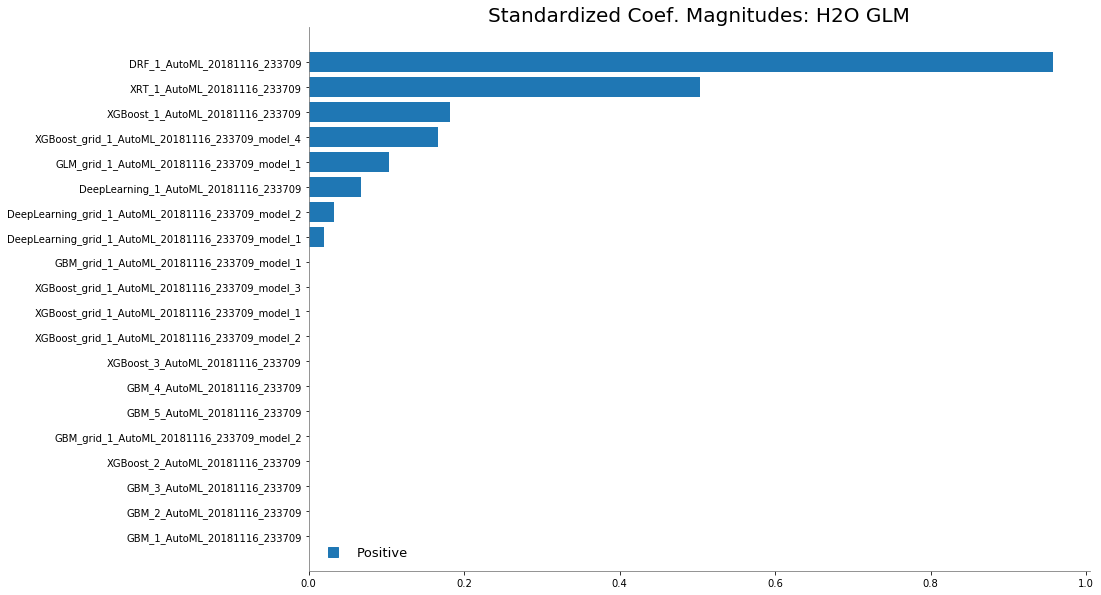

In [9]:
%matplotlib inline
metalearner.std_coef_plot()

In [10]:
aml.leader.download_mojo(path = "./product_model_bin/m20/v3/mojo", get_genmodel_jar = True)

'/home/siemanalyst/notebooks/siem/product_model_bin/m20/v2/mojo/StackedEnsemble_AllModels_AutoML_20181116_233709.zip'

In [4]:
spark.stop()